In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import keras
import tensorflow as tf


import numpy as np
import sys, os, glob, errno
sys.path.append("../../setigen")
import setigen as stg

tsamp = 1.4316557653333333
fch1 = 3751.464843051508
df = -1.3969838619232178e-06

fchans = 1024
tchans = 32

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

dir_name = '/datax/scratch/bbrzycki/data/obj_det_endpoints/'
csv_fn = dir_name + 'labels.csv'
model_fn = dir_name + 'model.h5'

In [3]:
# Load model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

model.load_weights(model_fn)

Prediction: [[406.09225 430.9432 ]]
Actual: 414 442.5605581057799
MSE: 98.74764418051085


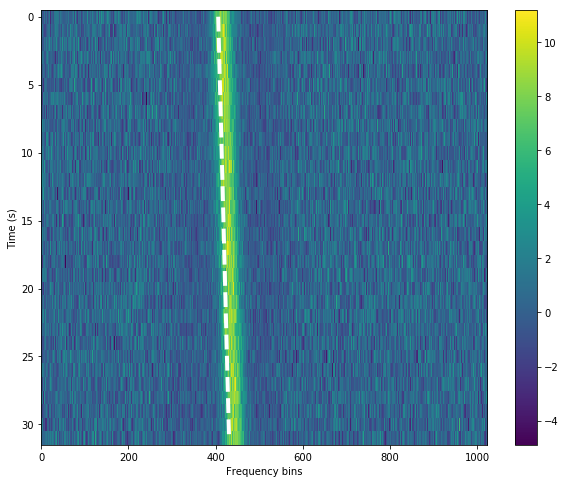

In [5]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans), (fchans-1-start_index)*df/(tsamp*tchans))
# drift_rate = 0
line_width = np.random.uniform(0.02, 0.03) ** 3
# line_width = np.random.uniform(0.04, 0.05) ** 3
level = 10

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

signal = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
reshaped_signal = np.array(signal).reshape(1,32,1024,1)

prediction = model.predict(reshaped_signal)
print('Prediction:', prediction)

# ps, pd, pl = prediction[0]
ps, pe = prediction[0]
fig = plt.figure(figsize=(10,8))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins')
plt.ylabel('Time (s)')

# box_width = 4 * np.abs(pl / df) + np.abs(pd / df * tsamp)
box_width = line_width
box_width = 4 * np.abs(line_width / df) + np.abs(drift_rate / df * tsamp)
# box_top = ps + pd / df * tsamp / 2
# box_top = len(fs) / 2
box_top = ps
box_bot = pe
# box_bot = box_top + drift_rate / df * tsamp * (tchans - 1) 
# box_bot = box_top + pd / df * tsamp * (tchans - 1) 
# print(box_top, box_bot, box_width)
end_index = (start_index + drift_rate / df * tsamp * (tchans - 1) )
print('Actual:', start_index, end_index)
print('MSE:', ((start_index - box_top)**2 + (end_index - box_bot)**2)/2)

plt.plot([box_top, box_bot], [0, tchans - 1], linewidth=4, linestyle='--', color='white')
# plt.plot([box_top - box_width/2, box_bot - box_width/2], [0, tchans - 1], linewidth=4, color='red')
# plt.plot([box_top + box_width/2, box_bot + box_width/2], [0, tchans - 1], linewidth=4, color='red')

# print((drift_rate - pd)**2)

# plt.savefig('noisy.pdf', bbox_inches='tight')
plt.show()

Prediction: [[-8.897813e-06]]
-1.4854472576013976e-06


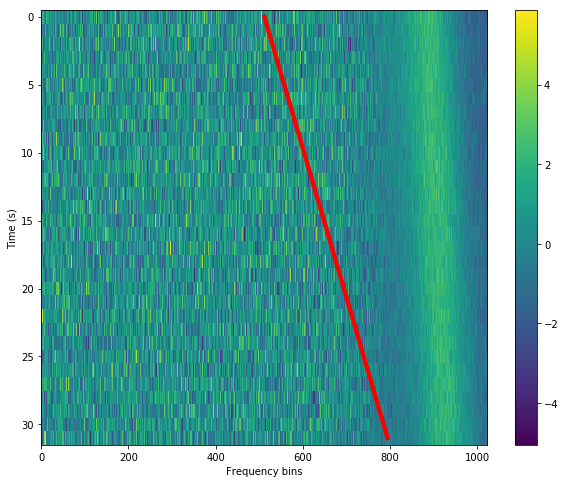

In [19]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans), (fchans-1-start_index)*df/(tsamp*tchans))
# drift_rate = 0
line_width = np.random.uniform(0.02, 0.03) ** 3
line_width = np.random.uniform(0.04, 0.05) ** 3
level = 10

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

signal = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
reshaped_signal = np.array(signal).reshape(1,32,1024,1)

prediction = model.predict(reshaped_signal)
print('Prediction:', prediction)

# ps, pd, pl = prediction[0]
pd = prediction[0][0]
fig = plt.figure(figsize=(10,8))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins')
plt.ylabel('Time (s)')

# box_width = 4 * np.abs(pl / df) + np.abs(pd / df * tsamp)
box_width = line_width
# box_top = ps + pd / df * tsamp / 2
# box_top = len(fs) / 2
box_top = 512
box_bot = box_top + pd / df * tsamp * (tchans - 1) 
# print(box_top, box_bot, box_width)
print(drift_rate)
plt.plot([box_top, box_bot], [0, tchans - 1], linewidth=1, color='red')
plt.plot([box_top - box_width/2, box_bot - box_width/2], [0, tchans - 1], linewidth=4, color='red')
plt.plot([box_top + box_width/2, box_bot + box_width/2], [0, tchans - 1], linewidth=4, color='red')

# print((drift_rate - pd)**2)

# plt.savefig('noisy.pdf', bbox_inches='tight')
plt.show()

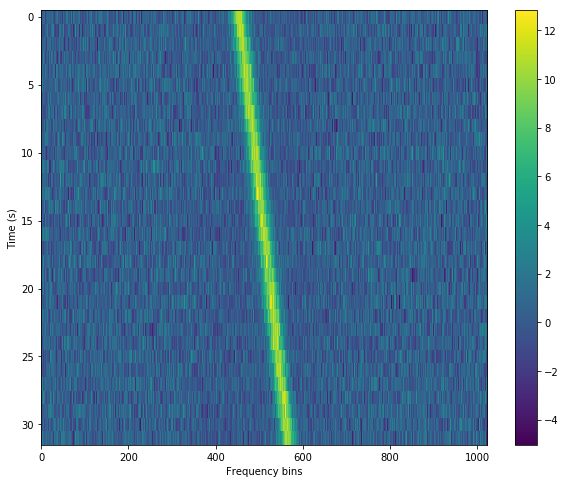

In [8]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans), (fchans-1-start_index)*df/(tsamp*tchans))
line_width = np.random.uniform(0.02, 0.03) ** 3
level = 10

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

signal = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)

fig = plt.figure(figsize=(10,8))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency bins')
plt.ylabel('Time (s)')

# plt.savefig('noisy.pdf', bbox_inches='tight')
plt.show()

In [3]:
# WITH WIDTHS
# Load model
model_fn_widths = dir_name + 'model_widths.h5'

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

model.load_weights(model_fn_widths)

               Start        End       Width
            -----------------------------------
Predicted:   823.03 Hz | 392.35 Hz | 18.14 Hz
Actual:      845.18 Hz | 383.35 Hz | 18.61 Hz


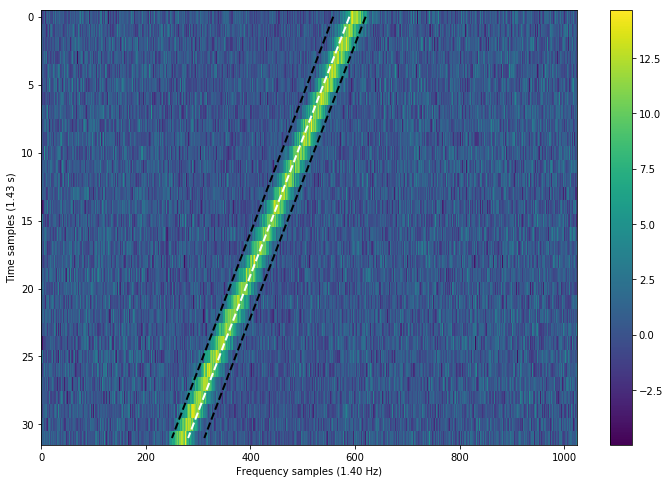

In [61]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans), (fchans-1-start_index)*df/(tsamp*tchans))
# drift_rate = 0
line_width = np.random.uniform(0.02, 0.03) ** 3
# line_width = np.random.uniform(0.04, 0.05) ** 3
level = 10

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

signal = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
reshaped_signal = np.array(signal).reshape(1,32,1024,1)

prediction = model.predict(reshaped_signal)

# ps, pd, pl = prediction[0]
ps, pe, pw = prediction[0]
pw = np.abs(pw * df / 32)

print('               Start        End       Width')
print('            -----------------------------------')

print('Predicted:   %4.2f Hz | %4.2f Hz | %.2f Hz' % (ps * -df * 1e6, pe * -df * 1e6, pw * 1e6))

fig = plt.figure(figsize=(12,8))
plt.imshow(signal, aspect='auto')
plt.colorbar()
plt.xlabel('Frequency samples (%2.2f Hz)' % (-df * 1e6))
plt.ylabel('Time samples (%2.2f s)' % tsamp)

# box_width = 4 * np.abs(pl / df) + np.abs(pd / df * tsamp)
box_width = line_width
pdrift_rate = (pe - ps) * df / (tsamp * (tchans - 1))
box_width = 4 * np.abs(pw / df) + np.abs(pdrift_rate / df * tsamp)
# box_top = ps + pd / df * tsamp / 2
# box_top = len(fs) / 2
box_top = ps
box_bot = pe
# box_bot = box_top + drift_rate / df * tsamp * (tchans - 1) 
# box_bot = box_top + pd / df * tsamp * (tchans - 1) 
# print(box_top, box_bot, box_width)
end_index = (start_index + drift_rate / df * tsamp * (tchans - 1) )

print('Actual:      %4.2f Hz | %4.2f Hz | %.2f Hz' % (start_index * -df * 1e6, end_index * -df * 1e6, line_width * 1e6))
MSE = ((start_index - box_top)**2 + (end_index - box_bot)**2 + ((line_width - pw) / df)**2)/3
# print('MSE:', MSE, '->', np.sqrt(MSE))

plt.plot([box_top, box_bot], [0, tchans - 1], linestyle='--', linewidth=2, color='white')
plt.plot([box_top - box_width/2, box_bot - box_width/2], [0, tchans - 1], linestyle='--', linewidth=2, color='black')
plt.plot([box_top + box_width/2, box_bot + box_width/2], [0, tchans - 1], linestyle='--', linewidth=2, color='black')

# print((drift_rate - pd)**2)

# plt.savefig('noisy.pdf', bbox_inches='tight')
plt.show()